In [1]:
import pandas as pd
import numpy as np
import gc
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import pickle

In [2]:
order_prior = pd.read_csv("order_products__prior.csv")
order_train = pd.read_csv('order_products__train.csv')
orders      = pd.read_csv("orders.csv")

In [3]:
temp = order_prior[["order_id",'reordered']].groupby('order_id').agg('sum')

none_prior=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
none_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,6,None,0,1
1,7,None,0,1
2,13,None,0,1
3,20,None,0,1
4,24,None,0,1


In [4]:
temp = order_train[["order_id",'reordered']].groupby('order_id').agg('sum')

none_train=pd.DataFrame({'order_id':temp[temp.reordered==0].index,'product_id':'None','add_to_cart_order':0,'reordered':1})
del temp
none_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,719,None,0,1
1,904,None,0,1
2,1571,None,0,1
3,2711,None,0,1
4,3227,None,0,1


In [5]:
order_train.order_id.nunique(),none_train.order_id.nunique()

(131209, 8602)

In [6]:
prior_data = pd.concat([order_prior.drop(['add_to_cart_order'],axis=1),none_prior.drop(['add_to_cart_order'],axis=1)])

prior_data.head()

,order_id,product_id,reordered
0,2,33120,1
1,2,28985,1
2,2,9327,0
3,2,45918,1
4,2,30035,0


In [7]:
train_data = pd.concat([order_train.drop(['add_to_cart_order'],axis=1),none_train.drop(['add_to_cart_order'],axis=1)])
train_data.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [8]:
prior_data = prior_data.merge(orders,on='order_id').fillna(0)
train_data = train_data.merge(orders,on='order_id',how='left').fillna(0)

### User_product_ratio

In [8]:
user_product_sum = prior_data.groupby(['user_id','product_id'])['reordered'].agg('sum').reset_index()
user_product_sum.columns = ['user_id','product_id','product_reordered']
user_product_sum.head()

,user_id,product_id,product_reordered
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2


In [9]:
user_sum = prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
user_sum.columns = ['user_id','total_reordered']
user_sum

,user_id,total_reordered
0,1,42
1,2,95
2,3,56
3,4,5
4,5,15
...,...,...
206204,206205,9
206205,206206,139
206206,206207,132
206207,206208,480


In [10]:
user_product_sum = user_product_sum.merge(user_sum,on='user_id')
user_product_sum['user_product_ratio'] = user_product_sum.product_reordered/user_product_sum.total_reordered
user_product_sum = user_product_sum.drop(['total_reordered','product_reordered'],axis=1)
user_product_sum.head()

,user_id,product_id,user_product_ratio
0,1,196,0.214286
1,1,10258,0.190476
2,1,10326,0.000000
3,1,12427,0.214286
4,1,13032,0.047619


In [11]:
pickle.dump(user_product_sum,open('user_product_ratio.pkl','wb'))

In [12]:
del user_sum,user_product_sum

In [16]:
train_data.shape

(1393219, 13)

## Day_of_week reorder_ratio

In [17]:
#reordered ratio of day of week
total_reorders = prior_data.reordered.sum()
dow_ratio = pd.DataFrame({'order_dow':pd.DataFrame(prior_data.groupby('order_dow')['reordered'].agg('sum')/total_reorders).index,
                          'dow_ratio':[i[0] for i in pd.DataFrame(prior_data.groupby('order_dow')['reordered'].agg('sum')/total_reorders).values]})
dow_ratio

,order_dow,dow_ratio
0,0,0.189491
1,1,0.178604
2,2,0.130305
3,3,0.118192
4,4,0.117277
5,5,0.131079
6,6,0.135051


In [18]:
pickle.dump(dow_ratio,open('day_of_week.pkl','wb'))

## Hour_of_day reordered ratio

In [19]:
## reorder ratio of the hour 
total_reorders = prior_data.reordered.sum()
hod_ratio = pd.DataFrame({'order_hour_of_day':pd.DataFrame(prior_data.groupby('order_hour_of_day')['reordered'].agg('sum')/total_reorders).index,
                          'hod_ratio':[i[0] for i in pd.DataFrame(prior_data.groupby('order_hour_of_day')['reordered'].agg('sum')/total_reorders).values]})
hod_ratio.head()

,order_hour_of_day,hod_ratio
0,0,0.006484
1,1,0.003383
2,2,0.002022
3,3,0.001506
4,4,0.001594


In [20]:
pickle.dump(hod_ratio,open('hour_of_week.pkl','wb'))

## Days_since_prior_order Reordered ratio

In [22]:
#days since prior_ratio
total_reorders = prior_data.reordered.sum()
dayprior = pd.DataFrame({'days_since_prior_order':pd.DataFrame(prior_data.groupby('days_since_prior_order')['reordered'].agg('sum')/total_reorders).index,
                          'daypriorratio':[i[0] for i in pd.DataFrame(prior_data.groupby('days_since_prior_order')['reordered'].agg('sum')/total_reorders).values]})
dayprior.head()

,days_since_prior_order,daypriorratio
0,0.0,0.027949
1,1.0,0.030558
2,2.0,0.049112
3,3.0,0.064915
4,4.0,0.072742


In [23]:
pickle.dump(dayprior,open('day_prior_ratio.pkl','wb'))

### Product hour of day reordered ratio

In [24]:
## product_hour reorderratio
temp = prior_data.groupby(['order_hour_of_day','product_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('product_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['product_id','total']
temp = temp.merge(temp1,on='product_id')
temp['product_hour_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_hour_of_day,product_id,product_hour_ratio
0,0,1,0.007042
1,1,1,0.009683
2,2,1,0.007042
3,3,1,0.002641
4,4,1,0.003521


In [25]:
pickle.dump(temp,open('product_hour_ratio.pkl','wb'))

## Product_dayofweek Ratio

In [8]:
## product_day reorderratio
temp = prior_data.groupby(['order_dow','product_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('product_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['product_id','total']
temp = temp.merge(temp1,on='product_id')
temp['product_day_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_dow,product_id,product_day_ratio
0,0,1,0.117958
1,1,1,0.232394
2,2,1,0.133803
3,3,1,0.135563
4,4,1,0.147887


In [9]:
pickle.dump(temp,open('product_day_week_ratio.pkl','wb'))

## User_dow reordered ratio

In [28]:
## product_day reorderratio
temp = prior_data.groupby(['order_dow','user_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['user_id','total']
temp = temp.merge(temp1,on='user_id')
temp['user_day_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_dow,user_id,user_day_ratio
0,0,3,0.660714
1,1,3,0.125000
2,2,3,0.017857
3,3,3,0.196429
4,0,5,0.266667


In [31]:
pickle.dump(temp,open('user_day_ratio.pkl','wb'))

## User hour reordered_ratio

In [36]:
## product_day reorderratio
temp = prior_data.groupby(['order_hour_of_day','user_id'])['reordered'].agg('sum').reset_index()
temp1= prior_data.groupby('user_id').agg({'reordered':'sum'}).reset_index()
temp1.columns=['user_id','total']
temp = temp.merge(temp1,on='user_id')
temp['user_hour_ratio'] = temp.reordered/temp.total
del temp1
temp = temp.drop(['reordered','total'],axis=1)
temp.head()

,order_hour_of_day,user_id,user_hour_ratio
0,0,8,0.428571
1,8,8,0.571429
2,0,38,0.083333
3,8,38,0.111111
4,9,38,0.120370


In [39]:
pickle.dump(temp,open('user_hour_ratio.pkl','wb'))

In [47]:
del prior_data,order_train,order_prior

## Days since prior order For a product

In [43]:
orders = orders[orders.eval_set=='prior'].fillna(0)

In [44]:
orders['cum_sum'] = orders.groupby('user_id')['days_since_prior_order'].agg('cumsum').values

In [45]:
orders['max_sum'] = orders.groupby('user_id')['cum_sum'].transform(max)

In [46]:
orders['since_order_product'] = orders['max_sum'] - orders['cum_sum']

In [47]:
order = orders[['order_id','user_id','since_order_product']]
order.head()

,order_id,user_id,since_order_product
0,2539329,1,176.0
1,2398795,1,161.0
2,473747,1,140.0
3,2254736,1,111.0
4,431534,1,83.0


In [48]:
user_since_product = pd.merge(order,order_prior[['order_id','product_id']]
                                   ,on='order_id')[['user_id','product_id','since_order_product']]


In [51]:
user_since_product = user_since_product.groupby(['user_id','product_id'])['since_order_product'].agg('min').reset_index()

In [57]:
user_since_product.head()

,user_id,product_id,since_order_product
0,1,196,0.0
1,1,10258,0.0
2,1,10326,83.0
3,1,12427,0.0
4,1,13032,0.0


In [58]:
pickle.dump(user_since_product,open('user_since_product.pkl','wb'))

## How many times product reordered by user

In [23]:
temp1 = prior_data[prior_data.reordered==1]

In [24]:
temp2 = temp1.groupby(['user_id','product_id']).agg({'reordered':'sum'}).reset_index()

In [26]:
temp2.columns=['user_id','product_id','user_times_product']

In [28]:
temp2.head()

,user_id,product_id,user_times_product
0,1,196,9
1,1,10258,8
2,1,12427,9
3,1,13032,2
4,1,13176,1


In [31]:
pickle.dump(temp2,open('user_times_product.pkl','wb'))

## W2V vectars of product and Departement and aisles

In [24]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
product     = pd.read_csv("products.csv")

In [25]:
product =product.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])
                                     ,columns=['product_id','product_name','aisle_id','department_id']))
aisles = aisles.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['aisle_id','aisle']))
departments = departments.append(pd.DataFrame(np.array([[str(None),str(None)]]),columns=['department_id','department']))

In [26]:
all_items = product.merge(departments,on='department_id').merge(aisles,on='aisle_id')

In [27]:
all_items = product.merge(departments,on='department_id').merge(aisles,on='aisle_id')

In [28]:
all_items['concat'] = all_items.product_name+' '+all_items.aisle+' '+all_items.department

In [29]:
all_items.shape

(49689, 7)

In [30]:
del product,aisles,departments

In [31]:
vectars = []
for i in tqdm(all_items.concat):
    vectars.append(nlp(i).vector.tolist())

100%|███████████████████████████████████████████████████████████████████████████| 49689/49689 [05:27<00:00, 151.60it/s]


In [32]:
gc.collect()
vectars = np.array(vectars)

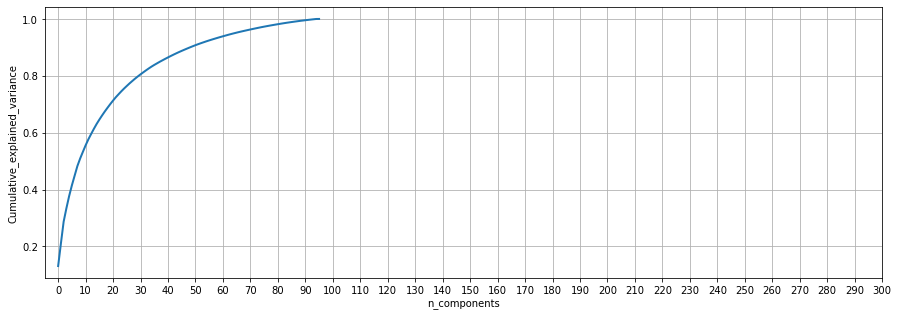

In [34]:
from sklearn.decomposition import PCA
pca = PCA(random_state=13)

# PCA for dimensionality redcution (non-visualization)

pca.n_components = 96
pca_data = pca.fit_transform(pd.DataFrame(vectars))

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(figsize=(15, 5))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.xticks([i for i in range(0,310,10)])
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 75-dimensions, approx. 90% of variance is expalined.

In [37]:
pca.n_components = 30
pca_data = pca.fit_transform(pd.DataFrame(vectars))
pca_data.shape

(49689, 30)

In [38]:
vectars = pd.DataFrame(pca_data)
vectars.columns = ["pca"+str(i) for i in vectars.columns]
vectars['product_id'] = all_items.product_id
vectars.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,product_id
0,5.686224,-3.038762,-2.743178,1.109000,-0.088164,-1.691640,-0.707614,-1.055068,-0.588087,0.677841,...,-0.716489,0.373045,-0.590969,0.073325,-0.465888,-1.154364,-0.081048,0.724124,-1.301621,1
1,1.764300,-1.805251,-1.871873,0.879540,0.347884,-1.049739,-1.054497,0.272715,-0.375633,-0.752400,...,-0.016262,-0.714879,-0.453696,-0.451633,-0.289947,-1.070607,0.076872,1.227828,-0.180647,78
2,5.245682,-3.529536,-1.308940,-0.370382,0.543120,-1.226690,-0.511356,-1.581898,-0.058176,0.077515,...,-0.734726,-0.356297,-0.784713,0.052657,-0.198003,-1.344156,-0.099784,-0.468944,-0.500759,102


In [39]:
pickle.dump(vectars,open('products_pca.pkl','wb'))

In [22]:
vectars = pickle.load(open('products_pca.pkl','rb'))

In [39]:
products = pd.read_csv('products.csv')
product =products.append(pd.DataFrame(np.array([[str(None),str(None),str(None),str(None)]])
                                     ,columns=['product_id','product_name','aisle_id','department_id'] ) )

In [40]:
product = product[['product_id','product_name']]

In [41]:
product.tail()

,product_id,product_name
49684,49685,En Croute Roast Hazelnut Cranberry
49685,49686,Artisan Baguette
49686,49687,Smartblend Healthy Metabolism Dry Cat Food
49687,49688,Fresh Foaming Cleanser
0,None,None


In [48]:
pro_dict = {}
for i in products.values:
    pro_dict[i[0]] = i[1]

In [51]:
pickle.dump(pro_dict,open('producIdName.pkl','wb'))